# 01: Data Preparation

This notebook performs the following steps to clean and prepare the raw Jarir transactions data:

- **Configuration**: Define paths, thresholds, and toggles  
- **Load Data**: Read raw Excel file into a DataFrame  
- **Date Parsing**: Handle custom date formats and ensure valid timestamps  
- **Column Standardization**: Rename raw columns to consistent names  
- **Price Computation**: Derive unit price from line amounts and quantities  
- **Filtering Steps**:
  1. Basic validity (missing values, returns, non-positive values, duplicates)  
  2. Text normalization & removal of non-product lines  
  3. Aggregation of duplicate transaction lines  
  4. Outlier detection & handling via IQR on log scale  
  5. Optional coverage filters to drop rare users/items  
- **Final Tables**:
  - Build `interactions_clean`, `item_catalog`, and `customer_table`  
  - Save to Parquet and export a quality report  
- **Optional Visual Checks**: Quick histograms for price, quantity, and line amounts

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import unicodedata, re, json
import matplotlib.pyplot as plt

# Paths
DATA_PATH = Path('../data/raw/jarir.xlsx')
OUT_DIR   = Path('../data/processed/jarir/')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Cleaning toggles / thresholds
KEEP_ONLY_POSITIVE_QTY         = True
KEEP_ONLY_POSITIVE_PRICE       = True
DROP_RETURNS_BY_INVOICE_PREFIX = True
DROP_DUPLICATE_ROWS            = True

# Non-product removal rules (description patterns; case-insensitive)
NON_PRODUCT_PATTERNS = [
    r'POSTAGE', r'SHIPPING', r'CARRIAGE', r'DELIVERY',
    r'BANK CHARGES', r'AMAZON', r'DOTCOM', r'PACKING',
    r'ADJUST', r'DISCOUNT', r'SAMPLE', r'SAMPLES',
    r'CHECK', r'TEST', r'MANUAL', r'FEE', r'CHARGE'
]

# Outlier handling (IQR on log values)
HANDLE_OUTLIERS                = True
WINSORIZE_INSTEAD_OF_DROP      = False
IQR_MULT                       = 3.0
LOG_EPS                        = 1e-6

# Coverage filters (optional; applied after core cleaning)
MIN_EVENTS_PER_USER            = 1
MIN_PURCHASES_PER_ITEM         = 1

# Randomness
torch_seed = 42
np.random.seed(torch_seed)

# Storage for quality metrics
quality = {}

## 1. Load Raw Data

- Read the Jarir dataset from Excel  
- Display original shape and column names

In [2]:
print("Loading Jarir dataset...")
raw = pd.read_excel(DATA_PATH, engine='openpyxl')
print(f"Original shape: {raw.shape}")
print(f"Columns: {raw.columns.tolist()}")

Loading Jarir dataset...
Original shape: (3001, 17)
Columns: ['Showroom', 'GL Class', 'Classification Description', 'ItemDescription', 'ShortItemNo', 'Model', 'Vendor Prefix', 'Brand', 'ItemNumber', 'Date', 'SalesChannel', 'CustomerId', 'Customer_VAT_Status', 'UNQTRN', 'Sales Quantity 2024', 'No of Trans 2024', 'Sales Amount 2024']


## 2. Parse Jarir Dates

- Custom parser for formats like `Jan-1`, `Feb-20`, etc.  
- Defaults year to 2024

In [3]:
def parse_jarir_dates(date_series):
    def parse_single(x):
        if pd.isna(x):
            return pd.NaT
        if isinstance(x, str) and '-' in x:
            m_str, d_str = x.split('-',1)
            month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
                         'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
            if m_str in month_map and d_str.isdigit():
                return pd.Timestamp(2024, month_map[m_str], int(d_str))
        return pd.NaT
    return pd.to_datetime(date_series.map(parse_single), errors='coerce')

## 3. Standardize Column Names

- Map raw Excel columns to our standard schema

In [4]:
rename_map = {
    'ItemNumber':'stock_code', 'ItemDescription':'description',
    'CustomerId':'customer_id', 'Sales Quantity 2024':'quantity',
    'Sales Amount 2024':'line_amount', 'Date':'invoice_date',
    'Showroom':'country', 'Brand':'brand', 'GL Class':'category',
    'Vendor Prefix':'vendor', 'Model':'model', 'ShortItemNo':'short_item_no',
    'SalesChannel':'sales_channel', 'Customer_VAT_Status':'vat_status',
    'UNQTRN':'unique_transaction', 'No of Trans 2024':'num_transactions'
}
for old, new in rename_map.items():
    if old in raw.columns:
        raw.rename(columns={old:new}, inplace=True)
print(f"After rename: {raw.columns.tolist()}")

After rename: ['country', 'category', 'Classification Description', 'description', 'short_item_no', 'model', 'vendor', 'brand', 'stock_code', 'invoice_date', 'sales_channel', 'customer_id', 'vat_status', 'unique_transaction', 'quantity', 'num_transactions', 'line_amount']


## 4. Apply Date Parsing & Price Computation

- Parse invoice dates  
- Generate synthetic dates if parsing fails entirely  
- Compute unit price = `line_amount / quantity`

In [5]:
raw['invoice_date'] = parse_jarir_dates(raw['invoice_date'])
if raw['invoice_date'].isna().all():
    raw['invoice_date'] = pd.date_range('2024-01-01', periods=len(raw), freq='D')
raw['price'] = raw['line_amount'] / raw['quantity']
print(f"Rows loaded: {len(raw)}")
raw.head(3)

Rows loaded: 3001


,country,category,Classification Description,description,short_item_no,model,vendor,brand,stock_code,invoice_date,sales_channel,customer_id,vat_status,unique_transaction,quantity,num_transactions,line_amount,price
0,0103-PLAZA,IN04 COMPUTER SUPPLIES,DFB COMPUTER CABLES,24-2PC54AAABB ADAPTER USB-C TO HDMI,493547,Pavilion,24- HEWLETT PACKARD (HP),HP,24-2PC54AAABB,2024-01-01,Showroom,18972653,1,20066638240101,1.0,1,77.39,77.390000
1,0103-PLAZA,IN10 ART & CRAFT SUPPLIES,CAE SPRAY PAINTS,O2.477041 SPRAY EV1050 VINTAGE YELLOW,539352,Vintage,O2. MONTANA CANS,MONTANA-CANS,O2.477041,2024-01-01,Showroom,35663471,1,20038904240101,3.0,1,86.09,28.696667
2,0103-PLAZA,IN12 COMPUTERS & PERIPHERALS,OAQ GAMING MONITOR,"16-LS32BG650EMXU SAMSUNG SMART GAMING 32"" 240HZ",628650,Odyssey,16- SAMSUNG ELECTRONICS SUZHOU COMPUTER CO.,Samsung,16-LS32BG650EMXU,2024-01-01,Showroom,23071472,1,20066758240101,1.0,1,1912.17,1912.170000


## 5. Step 1 — Basic Validity Filters

1. Drop rows missing critical fields  
2. Remove returns (prefix 'C')  
3. Keep only positive quantities & prices  
4. Drop exact duplicates

In [6]:
df = raw.copy()
before = len(df)
# 1) Missing core
core = df[['invoice_date','stock_code','description','country','customer_id']].notna().all(axis=1)
df = df[core]
quality['drop_missing_core'] = before - len(df)
# 2) Returns
if DROP_RETURNS_BY_INVOICE_PREFIX and 'unique_transaction' in df.columns:
    before = len(df)
    df = df[~df['unique_transaction'].astype(str).str.startswith('C', na=False)]
    quality['drop_returns'] = before - len(df)
# 3) Positive
if KEEP_ONLY_POSITIVE_QTY:
    before=len(df); df=df[df['quantity']>0]; quality['drop_nonpositive_qty']=before-len(df)
if KEEP_ONLY_POSITIVE_PRICE:
    before=len(df); df=df[df['price']>0]; quality['drop_nonpositive_price']=before-len(df)
# 4) Duplicates
if DROP_DUPLICATE_ROWS:
    before=len(df); df=df.drop_duplicates(); quality['drop_duplicates']=before-len(df)
print(f"After Step 1: {len(df)} rows")

After Step 1: 3001 rows


## 6. Step 2 — Text Normalization & Non-Product Removal

- Normalize whitespace & Unicode; uppercase  
- Drop lines matching non-product patterns

In [7]:
def normalize_text(s):
    if not isinstance(s,str): s = '' if pd.isna(s) else str(s)
    s = unicodedata.normalize('NFKC', s).strip()
    s = re.sub(r'\s+',' ', s)
    return s.upper()
pat = re.compile('|'.join(NON_PRODUCT_PATTERNS), flags=re.IGNORECASE)
df['description'] = df['description'].map(normalize_text)
df['stock_code'] = df['stock_code'].astype(str).str.upper()
before=len(df)
df = df[~df['description'].str.contains(pat)]
quality['drop_non_product_patterns']=before-len(df)
print(f"After Step 2: {len(df)} rows")

After Step 2: 2965 rows


## 7. Step 3 — Aggregate Duplicate Lines

- Aggregate repeated lines per (customer, item, date)

In [8]:
df['line_amount'] = df['quantity']*df['price']
before=len(df)
agg_cols={
    'quantity':'sum','price':'mean','line_amount':'sum',
    'description':'first','country':'first','brand':'first',
    'category':'first','vendor':'first','invoice_date':'first'
}
df = df.groupby(['customer_id','stock_code','invoice_date'], as_index=False).agg(agg_cols)
quality['aggregated_duplicate_lines']=before-len(df)
print(f"After Step 3: {len(df)} rows")

After Step 3: 2918 rows


## 8. Step 4 — Outlier Handling (IQR on log scale)

- Drop or winsorize outliers in `price`, `quantity`, `line_amount`

In [9]:
def iqr_bounds_log(s, mult=IQR_MULT, eps=LOG_EPS):
    ls=np.log(s.clip(lower=eps)).dropna()
    q1,q3=np.percentile(ls,[25,75]); iqr=q3-q1
    return np.exp(q1-mult*iqr), np.exp(q3+mult*iqr)
if HANDLE_OUTLIERS:
    p_lo,p_hi=iqr_bounds_log(df['price']); q_lo,q_hi=iqr_bounds_log(df['quantity'])
    a_lo,a_hi=iqr_bounds_log(df['line_amount'])
    mask=(df['price'].between(p_lo,p_hi)&df['quantity'].between(q_lo,q_hi)
          &df['line_amount'].between(a_lo,a_hi))
    before=len(df)
    if WINSORIZE_INSTEAD_OF_DROP:
        df['price']=df['price'].clip(p_lo,p_hi)
        df['quantity']=df['quantity'].clip(q_lo,q_hi)
        df['line_amount']=df['quantity']*df['price']
        removed=0
    else:
        df=df[mask]; removed=before-len(df)
    quality['drop_outliers']=removed
print(f"After Step 4: {len(df)} rows")

After Step 4: 2901 rows


## 9. Step 5 — Optional Coverage Filters

- Drop rare items/users based on thresholds

In [10]:
if MIN_PURCHASES_PER_ITEM>1:
    ic=df['stock_code'].value_counts()
    keep=ic[ic>=MIN_PURCHASES_PER_ITEM].index
    before=len(df); df=df[df['stock_code'].isin(keep)]; quality['drop_rare_items']=before-len(df)
if MIN_EVENTS_PER_USER>1:
    uc=df['customer_id'].value_counts()
    keep=uc[uc>=MIN_EVENTS_PER_USER].index
    before=len(df); df=df[df['customer_id'].isin(keep)]; quality['drop_rare_users']=before-len(df)
print(f"After Step 5: {len(df)} rows")

After Step 5: 2901 rows


## 10. Step 6 — Build & Save Final Tables

- Create `interactions_clean`, `item_catalog`, `customer_table`  
- Write to Parquet and export `quality_report.json`

In [12]:
interactions = ( df[['customer_id','invoice_date','stock_code','description',
                     'quantity','price','line_amount','country','brand','category','vendor']]
                 .sort_values(['customer_id','invoice_date']).reset_index(drop=True) )
# Item catalog ------------------------------------------------------------
item_catalog = (
    interactions.groupby('stock_code', as_index=False)
    .agg(
        description=('description', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        price_median=('price', 'median'),
        price_mean=('price', 'mean'),
        pop=('stock_code', 'size'),
        brand=('brand', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        category=('category', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        vendor=('vendor', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
    .sort_values('pop', ascending=False)
)

# Customer table ----------------------------------------------------------
customer_table=(interactions.groupby('customer_id',as_index=False)
    .agg(first_date=('invoice_date','min'), last_date=('invoice_date','max'),
         n_events=('invoice_date','nunique'),n_lines=('stock_code','size'),
         country_mode=('country',lambda s:s.mode().iat[0]),
         total_spent=('line_amount','sum')))
# Write
write_parquet_safe= lambda df,path: df.to_parquet(path,index=False,engine='pyarrow') if True else None
interactions.to_parquet(OUT_DIR/'interactions_clean.parquet',index=False,engine='pyarrow')
item_catalog.to_parquet(OUT_DIR/'items_clean.parquet',index=False,engine='pyarrow')
customer_table.to_parquet(OUT_DIR/'customers_clean.parquet',index=False,engine='pyarrow')

# Quality report
report={'counts':{'rows_initial':len(raw),'rows_final':len(interactions)},'quality':quality}
with open(OUT_DIR/'quality_report.json','w') as f: json.dump(report,f,indent=2)
print('✅ Data prep complete:', OUT_DIR)
report

✅ Data prep complete: ../data/processed/jarir


{'counts': {'rows_initial': 3001, 'rows_final': 2901},
 'quality': {'drop_missing_core': 0,
  'drop_returns': 0,
  'drop_nonpositive_qty': 0,
  'drop_nonpositive_price': 0,
  'drop_duplicates': 0,
  'drop_non_product_patterns': 36,
  'aggregated_duplicate_lines': 47,
  'drop_outliers': 17}}

## 11. Optional Visual Checks

- Histograms for `price`, `quantity`, and `line_amount`

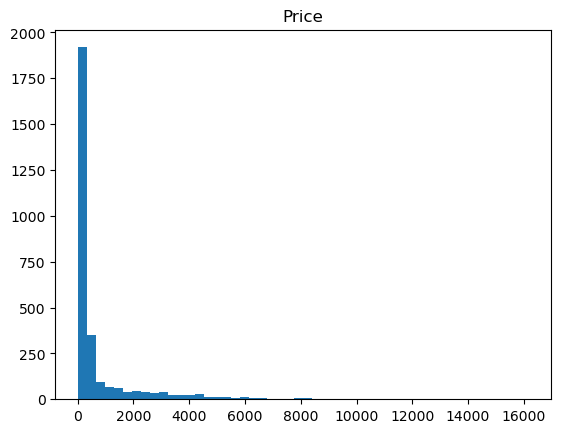

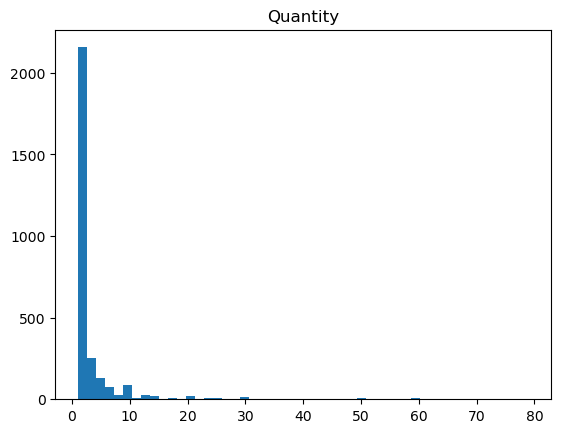

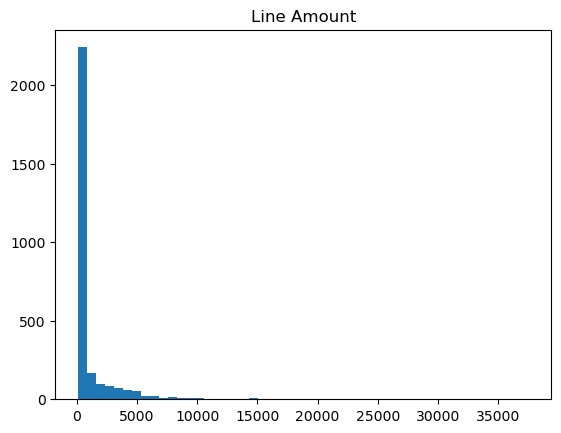

In [13]:
plt.figure(); plt.hist(interactions['price'], bins=50); plt.title('Price'); plt.show()
plt.figure(); plt.hist(interactions['quantity'], bins=50); plt.title('Quantity'); plt.show()
plt.figure(); plt.hist(interactions['line_amount'], bins=50); plt.title('Line Amount'); plt.show()

## 12. Step 7 — Build Train/Val/Test Sequences

- Generate user history → next-item samples  
- Split by global timestamps into 80% train, 10% val, 10% test  
- (Optional) add random negatives  
- Save `item_id_map`, `customer_id_map`, `sequences_train`, `sequences_val`, `sequences_test`

In [14]:
import pandas as pd, numpy as np

# Reload interactions if needed
if 'interactions' not in globals():
    interactions = pd.read_parquet(OUT_DIR/'interactions_clean.parquet')

# Config
HIST_MAX    = 15
MIN_HISTORY = 2
SPLIT_QS    = (0.80, 0.90)
SAVE_NEG    = False
N_NEG_TRAIN = 50
N_NEG_VAL   = 100

# Build ID maps
t_items = interactions['stock_code'].unique()
item_id_map = pd.DataFrame({'stock_code':t_items})
item_id_map['item_idx'] = np.arange(len(item_id_map), dtype=np.int64)

u_cust = interactions['customer_id'].unique()
customer_id_map = pd.DataFrame({'customer_id':u_cust})
customer_id_map['user_idx'] = np.arange(len(customer_id_map), dtype=np.int64)

# Merge indices
inter = (interactions
         .merge(item_id_map, on='stock_code')
         .merge(customer_id_map, on='customer_id')
         .sort_values(['customer_id','invoice_date'])
         .reset_index(drop=True))

t1 = inter['invoice_date'].quantile(SPLIT_QS[0])
t2 = inter['invoice_date'].quantile(SPLIT_QS[1])

def build_sequences(df, t_start, t_end):
    rows = []
    for uid, g in df.groupby('customer_id', sort=False):
        times = g['invoice_date'].to_numpy()
        items = g['item_idx'].to_numpy()
        users = g['user_idx'].to_numpy()
        country = g['country'].iloc[-1]
        for i in range(1, len(items)):
            if not (t_start <= times[i] < t_end):
                continue
            hist = items[max(0, i-HIST_MAX):i]
            if len(hist) < MIN_HISTORY:
                continue
            rows.append({
                'customer_id': uid,
                'user_idx': users[i],
                'ts': times[i],
                'history_idx': ' '.join(map(str,hist)),
                'pos_item_idx': int(items[i]),
                'country': country
            })
    return pd.DataFrame(rows)

seq_train = build_sequences(inter, inter['invoice_date'].min(), t1)
seq_val   = build_sequences(inter, t1, t2)
seq_test  = build_sequences(inter, t2, inter['invoice_date'].max()+pd.Timedelta(seconds=1))

# (Optional) add negatives
def add_random_negs(df, n):
    rng = np.random.default_rng(SEED)
    pool = item_id_map['item_idx'].to_numpy()
    negs = []
    for h, p in zip(df['history_idx'], df['pos_item_idx']):
        forbid = set(map(int,h.split())) | {p}
        choices = pool[~np.isin(pool, list(forbid))]
        if len(choices)==0:
            negs.append('')
        else:
            take = rng.choice(choices, size=min(n,len(choices)), replace=False)
            negs.append(' '.join(map(str,take)))
    df['neg_idx'] = negs
    return df

if SAVE_NEG:
    seq_train = add_random_negs(seq_train, N_NEG_TRAIN)
    seq_val   = add_random_negs(seq_val,   N_NEG_VAL)
    seq_test  = add_random_negs(seq_test,  N_NEG_VAL)

# Save all
def save(df,name):
    path = OUT_DIR/f"{name}.parquet"
    df.to_parquet(path, index=False, engine='pyarrow')
    print(f"Saved {name}: {df.shape}")

save(item_id_map, 'item_id_map')
save(customer_id_map, 'customer_id_map')
save(seq_train, 'sequences_train')
save(seq_val, 'sequences_val')
save(seq_test, 'sequences_test')

Saved item_id_map: (1735, 2)
Saved customer_id_map: (929, 2)
Saved sequences_train: (1108, 6)
Saved sequences_val: (169, 6)
Saved sequences_test: (160, 6)
